In [17]:
%matplotlib inline
import fsps
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

* add_igm_absorption includes IGM absorption via Madau 1995
* zred is redshift
* zmet = 1.0 by default, metallicity 
* sfh = 0 is SSP model (all stars have same age and metallicity) 
* tage = Myr age
* sfh = tabular sfr per year since big bang
* dust_type = 2; See Calzetti et al 2000. Dust attenuation is applied to all starlight equally (old and new). This is set by dust_2
* dust_2 small attenuation due to ISM dust for all stars. 

In [2]:
sp = fsps.StellarPopulation(zred=3., const=1.0, sfh=3, tage=0.5, add_igm_absorption=True,
                            zmet = 1., dust1=0.0, dust2=0.1, dust_type=2 )

Create arrays of age since big bang in Gyr and the constant star formation rate of 5 solar mass / yr.

In [3]:
a = np.arange(0.1, 0.6, 0.1)
sfr = np.full(5, 5.0)

Set the star formation history with a constant star formation rate.

In [4]:
sp.set_tabular_sfh(age = a, sfr = sfr)

Below we print the AB magnitudes in desired bands. They are extremely faint right now and I think this is because the star formation rate is by default normalized to 1. I need to figure out how to make it 5. 

In [5]:
mags = sp.get_mags(zmet = 1., tage=0.5, bands=['wfc_acs_f435w', 'wfc_acs_f606w', 'wfc_acs_f775w', 'wfc_acs_f850lp', 'wfc3_ir_f105w', 'wfc3_ir_f125w', 'wfc3_ir_f160w', 'jwst_f200w', 'jwst_f277w', 'jwst_f356w', 'jwst_f444w'])
print 'HST F435W: ', mags[0]
print 'HST F606W: ', mags[1]
print 'HST F775W: ', mags[2]
print 'HST F850LP: ', mags[3]
print 'HST F105W: ', mags[4]
print 'HST F125W: ', mags[5]
print 'HST F160W: ', mags[6]
print 'JWST F200W: ', mags[7]
print 'JWST F277W: ', mags[8]
print 'JWST F356W: ', mags[9]
print 'JWST F444W: ', mags[10]

HST F435W:  25.685180586652734
HST F606W:  25.194646169018057
HST F775W:  25.245591101064576
HST F850LP:  25.313704531210405
HST F105W:  25.38336539406353
HST F125W:  25.46820026206371
HST F160W:  25.3068973512635
JWST F200W:  25.295006040237567
JWST F277W:  25.480190802455958
JWST F356W:  25.567011528475433
JWST F444W:  25.641540680718585


In [13]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

In [14]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
r=cosmo.luminosity_distance(3).to(u.m).value
print r
cosmo.luminosity_distance(3)

8.03485249278e+26


<Quantity 26039.18355256 Mpc>

In [15]:
spec = spec * (3.828E26) # L_sol/Hz to W/Hz
spec = spec / (1.0E-26) # W/Hz to Jy*m^2 (1 Jy = 10^-26 W/Hz/m^2)
spec = spec / (1.0E-6) # convert to microJy
spec = spec / (4*np.pi*(r**2)) # divide by surface area from galaxy Jy*m^2 to Jy
# print spec
# 
# print spec
# spec = spec / (1.0E-6) # convert to microJy
# print spec

In [9]:
lyman_lim=912. #angstroms

/Users/fardila/anaconda/envs/radiation/lib/python2.7/site-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


(1e-10, 1.0)

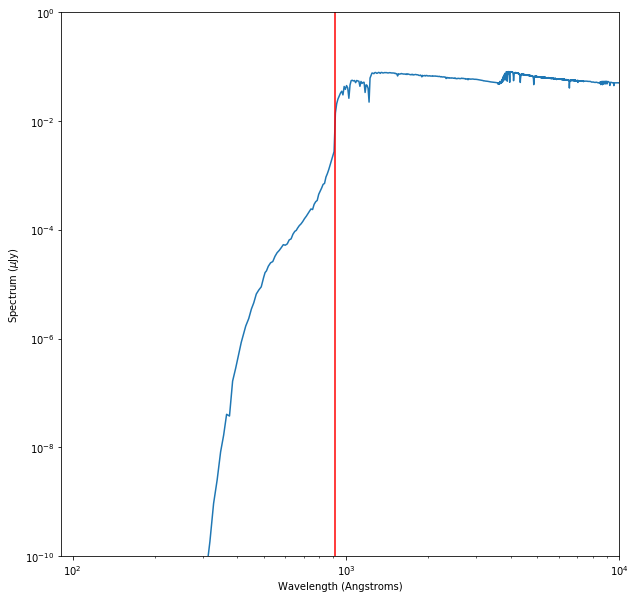

In [10]:
fig = plt.figure(figsize=[10,10])
plt.plot(wave, spec)
plt.axvline(lyman_lim, c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectrum ($\mu$Jy)')
plt.xlim(0,1e4)
plt.ylim(1e-10,1e0)

# Get Lyman continuum photon count

In [62]:
from astropy.constants import h, c

In [63]:
print h
print c

  Name   = Planck constant
  Value  = 6.62607004e-34
  Uncertainty  = 8.1e-42
  Unit  = J s
  Reference = CODATA 2014
  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2014


In [64]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = (nodes - node)**2
    return np.argmin(dist_2)

In [70]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5, peraa=True)

In [71]:
spec = spec * (3.828E26) # L_sol/AA to W/AA (i.e. J/s/AA)
wave_m = wave * (1e-10) #Angstroms to meters
energies = (h.value*c.value)/wave_m #in J
photon_count_per_wavelength = spec / energies # 1/s/AA

In [72]:
wave[:closest_node(lyman_lim, wave)+1]

array([ 91.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110., 114.,
       118., 121., 125., 127., 128., 131., 132., 134., 137., 140., 143.,
       147., 151., 155., 159., 162., 166., 170., 173., 177., 180., 182.,
       186., 191., 194., 198., 202., 205., 210., 216., 220., 223., 227.,
       230., 234., 240., 246., 252., 257., 260., 264., 269., 274., 279.,
       284., 290., 296., 301., 308., 318., 328., 338., 348., 357., 366.,
       375., 385., 395., 405., 414., 422., 430., 441., 451., 460., 470.,
       480., 490., 500., 506., 512., 520., 530., 540., 550., 560., 570.,
       580., 590., 600., 610., 620., 630., 640., 650., 658., 665., 675.,
       685., 695., 705., 716., 726., 735., 745., 755., 765., 775., 785.,
       795., 805., 815., 825., 835., 845., 855., 865., 875., 885., 895.,
       905., 915.])

In [73]:
#integrate over Lyman wavelengths to get photon gocunt
photon_count = np.trapz(photon_count_per_wavelength[:closest_node(lyman_lim, wave)+1], 
                        wave[:closest_node(lyman_lim, wave)+1]) 

In [74]:
print photon_count

3.636009743895974e+52


# Plot SEDs with photometric points 

In [ ]:
def get_filter_bounds(transmissions, wavelengths):
    length = len(transmissions)
    
    l_bound = closest_node(0.1, transmissions[:length/2])
    r_bound = closest_node(0.1, transmissions[length/2:])
    
    return wavelengths[l_bound], wavelengths[(length/2) + r_bound]


Text(0,0.5,u'Transmission')

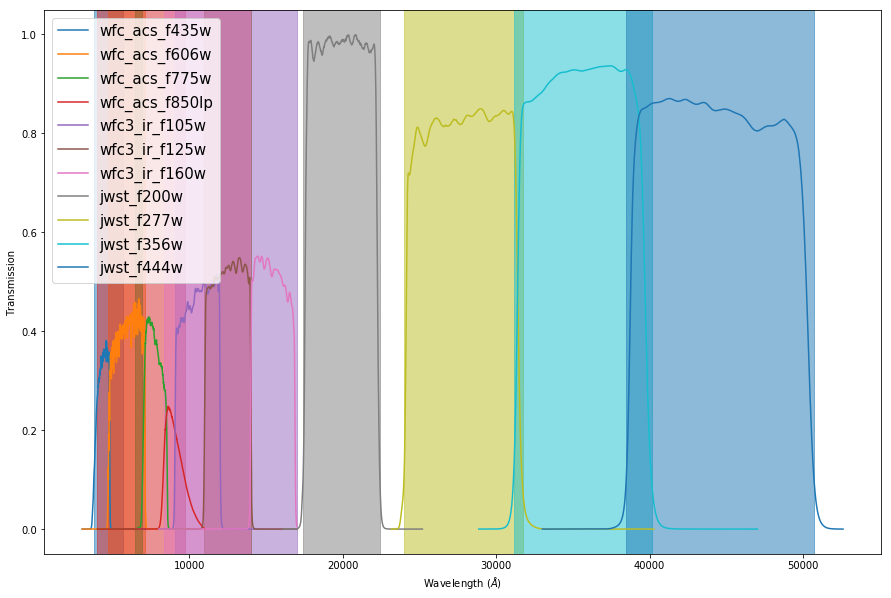

In [93]:
photometry_bands = ['wfc_acs_f435w','wfc_acs_f606w','wfc_acs_f775w','wfc_acs_f850lp','wfc3_ir_f105w','wfc3_ir_f125w',
             'wfc3_ir_f160w','jwst_f200w','jwst_f277w','jwst_f356w','jwst_f444w']
wavelengths =[]
transmissions = []
plt.figure(figsize=[15,10])
for band in photometry_bands:
    b = fsps.get_filter(band)
    wavelength,transmission = b.transmission
    
    wavelengths.append(wavelength)
    transmissions.append(transmission)
    
    p = plt.plot(wavelength,transmission,label=band)
        
    l_bound, r_bound = get_filter_bounds(transmission, wavelength)
    plt.axvspan(l_bound, r_bound, alpha=0.5, color= p[0].get_color())
    
    
plt.legend(loc='upper left', fontsize=15)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Transmission')    

In [94]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

In [95]:
spec = spec * (3.828E26) # L_sol/Hz to W/Hz
spec = spec / (1.0E-26) # W/Hz to Jy*m^2 (1 Jy = 10^-26 W/Hz/m^2)
spec = spec / (1.0E-6) # convert to microJy
spec = spec / (4*np.pi*(r**2)) # divide by surface area from galaxy Jy*m^2 to Jy

(0.01, 2)

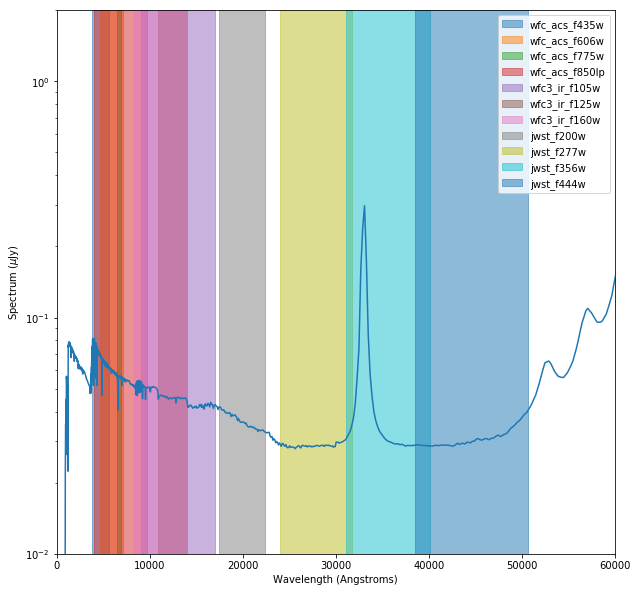

In [112]:
fig = plt.figure(figsize=[10,10])
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#1f77b4']

for i, band in enumerate(photometry_bands):
    b = fsps.get_filter(band)
    wavelength,transmission = b.transmission
       
    l_bound, r_bound = get_filter_bounds(transmission, wavelength)
    plt.axvspan(l_bound, r_bound, alpha=0.5, color= new_colors[i], label=band)
    
plt.plot(wave, spec)
plt.legend()
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectrum ($\mu$Jy)')
plt.xlim(0,6e4)
plt.ylim(1e-2,2)

HST bands have a lot of overlap. JWST bands do not.